In [ ]:
import os
import numpy as np
import pydicom
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [2]:



# Set base paths
image_path_base = r'C:\ML Data\Chinesearchive\TheChineseMammographyDatabase\cmmd png 2'
text_path_base = r'C:\ML Data\Chinesearchive\TheChineseMammographyDatabase\cleanCropCMMD.csv'

def get_image_paths_and_labels():
    image_paths = []
    labels = []
    b_count = 0
    M_count = 0

    with open(text_path_base) as f:
        f.readline()  # Skip header

        for line in f:
            splitLine = line.split(",")

            imagePath = splitLine[2].replace("\n", "").replace('"', "")
            imagePath = imagePath.replace('C:\\ML Data\\Chinesearchive\\TheChineseMammographyDatabase\\CMMD png 2\\', image_path_base + '/')
            full_image_path = os.path.join(image_path_base, imagePath.strip())

            image_paths.append(full_image_path)

            classification = splitLine[1].replace('"', '').strip()
            if classification == "0":
                labels.append(np.array([0]))
                b_count += 1
            elif classification == "1":
                labels.append(np.array([1]))
                M_count += 1

    print(f"Benign count: {b_count}")
    print(f"Malignant count: {M_count}")
    return np.array(image_paths), np.array(labels)

# original image paths and labels
image_paths, labels = get_image_paths_and_labels()

# separate benign and malignant paths
benign_paths = image_paths[labels.flatten() == 0]
malignant_paths = image_paths[labels.flatten() == 1]

# B\balance the dataset
num_to_augment = len(malignant_paths) - len(benign_paths)
print(f"\nNeed to augment {num_to_augment} benign images.")


Benign count: 1416
Malignant count: 4174

Need to augment 2758 benign images.


In [8]:

augmented_dir = os.path.join(image_path_base, "augmented_benign")
os.makedirs(augmented_dir, exist_ok=True)

augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generate augmented benign images
augmented_paths = []
count = 0
i = 0

while count < num_to_augment:
    img_path = benign_paths[i % len(benign_paths)]
    try:
        img = load_img(img_path)
    except Exception as e:
        print(f"Skipping {img_path} due to error: {e}")
        i += 1
        continue

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    for batch in augmenter.flow(x, batch_size=1):
        new_filename = f"benign_aug_{count}.png"
        new_path = os.path.join(augmented_dir, new_filename)

        array_to_img(batch[0]).save(new_path)
        augmented_paths.append(new_path)
        count += 1
        print(f"count: {count}")
        break  # Save 1 per image

    i += 1

print(f"\nSaved {len(augmented_paths)} augmented benign images.")

# Combine original + augmented data
augmented_labels = np.zeros((len(augmented_paths), 1))

image_paths_balanced = np.concatenate([image_paths, np.array(augmented_paths)])
labels_balanced = np.concatenate([labels, augmented_labels])

# Shuffle
indices = np.arange(len(image_paths_balanced))
np.random.shuffle(indices)

image_paths_balanced = image_paths_balanced[indices]
labels_balanced = labels_balanced[indices]

print(f"\nFinal training set: {len(image_paths_balanced)} images (Benign: {np.sum(labels_balanced == 0)}, Malignant: {np.sum(labels_balanced == 1)})")



count: 1
count: 2
count: 3
count: 4
count: 5
count: 6
count: 7
count: 8
count: 9
count: 10
count: 11
count: 12
count: 13
count: 14
count: 15
count: 16
count: 17
count: 18
count: 19
count: 20
count: 21
count: 22
count: 23
count: 24
count: 25
count: 26
count: 27
count: 28
count: 29
count: 30
count: 31
count: 32
count: 33
count: 34
count: 35
count: 36
count: 37
count: 38
count: 39
count: 40
count: 41
count: 42
count: 43
count: 44
count: 45
count: 46
count: 47
count: 48
count: 49
count: 50
count: 51
count: 52
count: 53
count: 54
count: 55
count: 56
count: 57
count: 58
count: 59
count: 60
count: 61
count: 62
count: 63
count: 64
count: 65
count: 66
count: 67
count: 68
count: 69
count: 70
count: 71
count: 72
count: 73
count: 74
count: 75
count: 76
count: 77
count: 78
count: 79
count: 80
count: 81
count: 82
count: 83
count: 84
count: 85
count: 86
count: 87
count: 88
count: 89
count: 90
count: 91
count: 92
count: 93
count: 94
count: 95
count: 96
count: 97
count: 98
count: 99
count: 100
count: 1

In [9]:


# Split into training and testing sets (80/20 split)
paths_train, paths_test, y_train, y_test = train_test_split(
    image_paths_balanced,
    labels_balanced,
    test_size=0.2,
    random_state=42,
    stratify=labels_balanced  # ensures same class distribution
)

print(f"Training set: {len(paths_train)} images")
print(f"Test set: {len(paths_test)} images")

Training set: 6678 images
Test set: 1670 images


In [10]:
class DataGenerator:
    def __init__(self, image_paths, labels, batch_size=32, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:

            img = load_img(path, color_mode='rgb')
            img_array = img_to_array(img)
            img_tensor = tf.convert_to_tensor(img_array)
            img = tf.image.resize_with_pad(img_tensor, 600, 600)
            batch_images.append(img)

        X = np.array(batch_images)
        y = np.array(batch_labels).reshape(-1, 1)

        if self.augment:
            for i in range(len(X)):
                if np.random.random() > 0.5:
                    X[i] = self.datagen.random_transform(X[i])

        return X, y

    def generate(self):
        while True:
            indices = np.random.permutation(len(self.image_paths))
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

            for i in range(len(self)):
                yield self.__getitem__(i)

train_gen = DataGenerator(paths_train, y_train, batch_size=32, augment=True)
test_gen = DataGenerator(paths_test, y_test, batch_size=32, augment=False)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = y_train.flatten().astype(int)

print(np.unique(y_train_labels))
print("Class distribution:", np.bincount(y_train_labels))

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))

print("Class Weights:", class_weight_dict)


[0 1]
Class distribution: [3339 3339]
Class Weights: {0: 1.0, 1: 1.0}


In [12]:


# Load best saved weights
model =  load_model(r'C:\Users\gabel\Desktop\Models to Evaluate\dropoutandl2andoversampling.keras')
print("Best weights loaded for evaluation.")


def evaluate_model(model, generator, steps, model_name="Model"):
    suffix = "_UNaugmented_unbalanced"  # <-- change as needed
    if hasattr(generator, 'on_epoch_end'):
        generator.on_epoch_end()

    y_true = []
    y_pred_prob = []

    for i in range(steps):
        if hasattr(generator, '__getitem__'):
            batch_x, batch_y = generator.__getitem__(i)
        else:
            batch_x, batch_y = next(generator.generate())

        batch_pred = model.predict(batch_x, verbose=0)

        y_true.extend(batch_y)
        y_pred_prob.extend(batch_pred)

    y_true = np.array(y_true).flatten()
    y_pred_prob = np.array(y_pred_prob).flatten()

    y_pred = (y_pred_prob > 0.5).astype(int)

    # --- Classification Report ---
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    #--- CHANGE THIS FILE PATH
    #cm_path = '/Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix.png'


    cm_path = f'/Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix{suffix}.png'

    plt.savefig(cm_path)
    print(f"Confusion matrix saved to: {cm_path}")
    plt.close()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")


    #CHANGE THIS FILE PATH----
    roc_path = f'/Users/elianafreedman/Desktop/cropped cmmd/ROC{suffix}.png'
    plt.savefig(roc_path)
    print(f"ROC curve saved to: {roc_path}")
    plt.close()

#evaluate_model(model, test_gen, steps=10)



Best weights loaded for evaluation.


In [15]:
evaluate_model(model, test_gen, steps=len(test_gen), model_name="Augmented_benign_data" )

KeyboardInterrupt: 

In [ ]:
# actual test sob (remove anything in the augmented benign list)
original_test_paths = [p for p in paths_test if "augmented_benign" not in p]
original_test_labels = y_test[[i for i, p in enumerate(paths_test) if "augmented_benign" not in p]]

original_test_gen = DataGenerator(original_test_paths, original_test_labels, batch_size=32, augment=False)




In [17]:
y_orig_test = original_test_labels.flatten().astype(int)
unique, counts = np.unique(y_orig_test, return_counts=True)

print("Original test set class distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label} ({'Benign' if label == 0 else 'Malignant'}): {count}")

Original test set class distribution:
Class 0 (Benign): 299
Class 1 (Malignant): 835



--- CNN (Non augmented, Unbalanced) Classification Report ---
              precision    recall  f1-score   support

      Benign       0.41      0.47      0.44       299
   Malignant       0.80      0.75      0.78       835

    accuracy                           0.68      1134
   macro avg       0.60      0.61      0.61      1134
weighted avg       0.70      0.68      0.69      1134



FileNotFoundError: [Errno 2] No such file or directory: '/Users/elianafreedman/Desktop/cropped cmmd/confusionmatrix_UNaugmented_unbalanced.png'

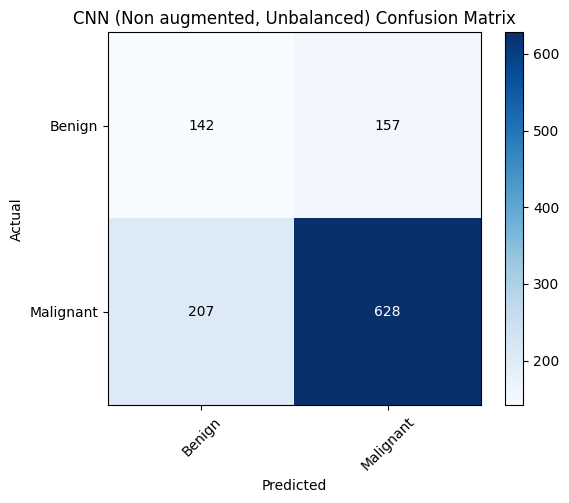

In [19]:
#on skewed classes but non augmented
evaluate_model(model, original_test_gen, steps=len(original_test_gen), model_name="CNN (Non augmented, Unbalanced)"),
